In [1]:
import cv2

import os
import shutil

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as kr
from tensorflow.keras import models,layers

In [2]:
cascpath="haarcascade_frontalface_default.xml"
classifier= cv2.CascadeClassifier(cascpath)

In [3]:
def datagen():
    
    print("Enter your id: ")
    img_id=input().strip()

    parent_dir="D:\JupyterNoteBook\MiniProject4\Dataset"
    path = os.path.join(parent_dir,img_id)
    if os.path.exists(path):
        shutil.rmtree(path)
    os.mkdir(path)
    
    cap = cv2.VideoCapture(0)
    #img_id = 0
    c=0
    while True:
        ret, frame = cap.read()
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = classifier.detectMultiScale(gray, 1.3, 5)
        
        #if faces is ():
        #    return None
        for (x,y,w,h) in faces:
            cropped_face = frame[y:y+h,x:x+w]
            c+=1
            if cropped_face is not None:
                face = cv2.resize(cropped_face, (256,256))
                face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
                file_name_path = "Dataset/"+img_id+"/"+str(c)+'.jpg'
                cv2.imwrite(file_name_path, face)
                cv2.putText(face, str(c), (50,50), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2 )
            
                cv2.imshow("Cropped_Face", face)
        if cv2.waitKey(1)==13 or c==100:
            break
                
    cap.release()
    cv2.destroyAllWindows()
    print("Collecting samples is completed !!!")
    

In [10]:
datagen()

Enter your id: 
9


In [4]:
imgsize=256
batchsize=10
channels=3
epochs=5

In [5]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    shuffle=True,
    image_size=(imgsize,imgsize),
    batch_size=batchsize
)

Found 800 files belonging to 8 classes.


In [6]:
classnm=dataset.class_names
nclasses=len(classnm)

In [7]:
nclasses

8

In [8]:
classnm

['1', '2', '3', '4', '5', '6', '7', '8']

In [9]:
len(dataset)

80

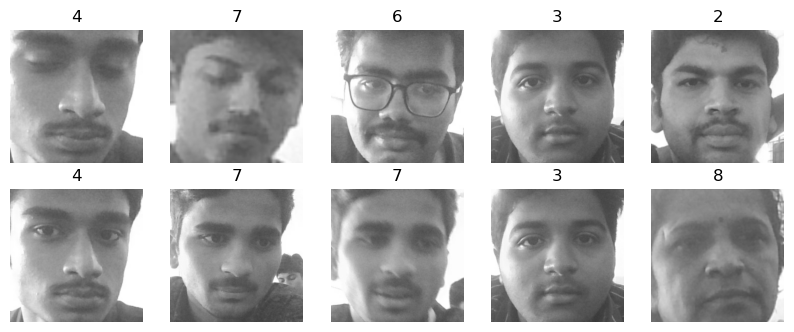

In [10]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(10):
        plt.subplot(5,5,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))   
        plt.title(classnm[label_batch[i]])
        plt.axis("off")

In [11]:
def getdatasetpartitions(ds,trainsplit=0.8,valsplit=0.1,testsplit=0.1,shuffle=True,shufflesize=10000):
    dssize=len(ds)
    
    if shuffle:
        ds=ds.shuffle(shufflesize,seed=12)
    
    trainsize=int(trainsplit*dssize)
    valsize=int(valsplit*dssize)
    
    trainds=ds.take(trainsize)
    
    valds=ds.skip(trainsize).take(valsize)
    testds=ds.skip(trainsize).skip(valsize)
    
    return trainds,valds,testds

In [12]:
trainds,valds,testds=getdatasetpartitions(dataset)

In [13]:
len(trainds)

64

In [14]:
len(valds)

8

In [15]:
len(testds)

8

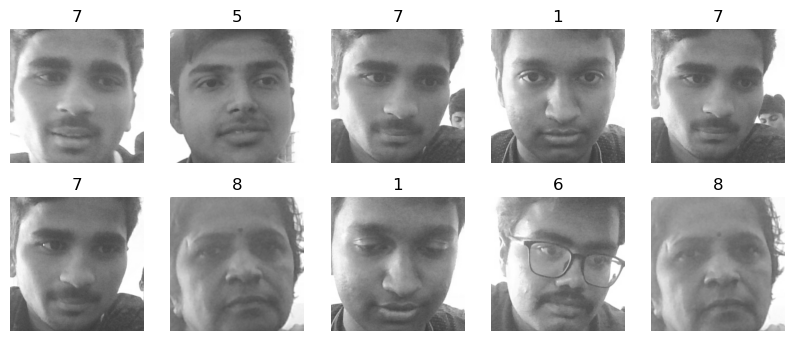

In [16]:
plt.figure(figsize=(10,4))
for image_batch,label_batch in trainds.take(1):
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))   
        plt.title(classnm[label_batch[i]])
        plt.axis("off")

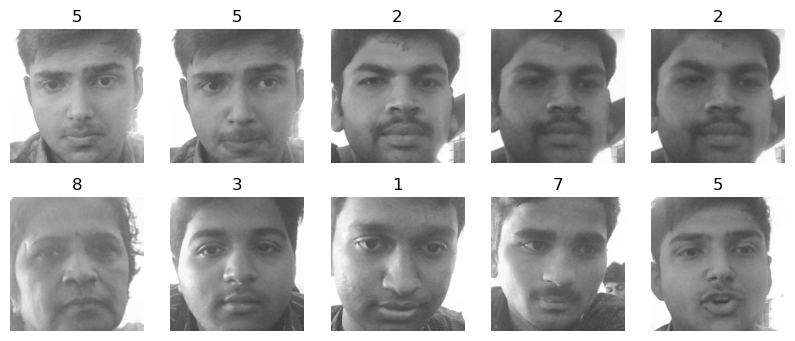

In [17]:
plt.figure(figsize=(10,4))
for image_batch,label_batch in valds.take(1):
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))   
        plt.title(classnm[label_batch[i]])
        plt.axis("off")

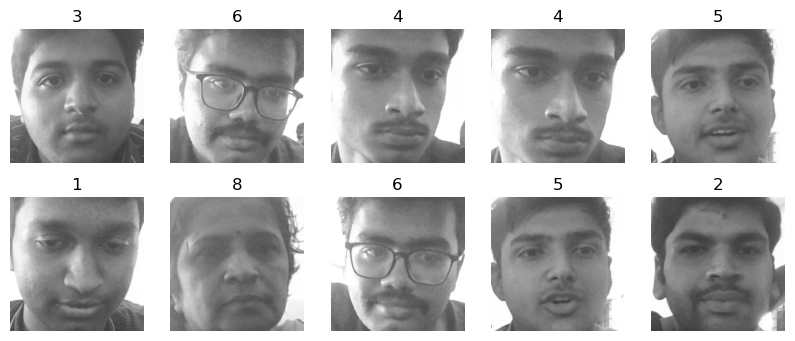

In [18]:
plt.figure(figsize=(10,4))
for image_batch,label_batch in testds.take(1):
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))   
        plt.title(classnm[label_batch[i]])
        plt.axis("off")

In [19]:
trainds=trainds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valds=valds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
testds=testds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_rescale_layer=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(imgsize,imgsize),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [21]:
data_augmentation_layer=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [22]:
inshape=(batchsize,imgsize,imgsize,channels)
nclasses=8
model=models.Sequential([
    resize_rescale_layer,
    #data_augmentation_layer,
    layers.Conv2D(10,(3,3),activation='relu',input_shape=inshape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(nclasses,activation='softmax'),
])

model.build(input_shape=inshape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (10, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (10, 254, 254, 10)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (10, 127, 127, 10)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (10, 125, 125, 64)        5824      
                                                                 
 max_pooling2d_1 (MaxPooling  (10, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (10, 246016)             

In [24]:
opt = kr.optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    #loss=tf.keras.losses.CategoricalCrossentropy(), 
    metrics=['accuracy']
)

In [25]:
for image_batch,label_batch in trainds.take(1):
    print(image_batch.shape)
    print(label_batch.shape)

(10, 256, 256, 3)
(10,)


In [26]:
history=model.fit(
    trainds,
    epochs=epochs,
    batch_size=batchsize,
    verbose=1,
    validation_data=valds
)

Epoch 1/5
64/64 [==============================] - 45s 660ms/step - loss: 1.6757 - accuracy: 0.4500 - val_loss: 0.9339 - val_accuracy: 0.8375
Epoch 2/5
64/64 [==============================] - 38s 591ms/step - loss: 0.5730 - accuracy: 0.8969 - val_loss: 0.1805 - val_accuracy: 0.9875
Epoch 3/5
64/64 [==============================] - 38s 593ms/step - loss: 0.1802 - accuracy: 0.9688 - val_loss: 0.1168 - val_accuracy: 0.9875
Epoch 4/5
64/64 [==============================] - 39s 608ms/step - loss: 0.0984 - accuracy: 0.9812 - val_loss: 0.0933 - val_accuracy: 0.9875
Epoch 5/5
64/64 [==============================] - 40s 628ms/step - loss: 0.0872 - accuracy: 0.9844 - val_loss: 0.0650 - val_accuracy: 0.9875


In [27]:
scores=model.evaluate(testds)

8/8 [==============================] - 2s 152ms/step - loss: 0.0214 - accuracy: 1.0000


In [75]:
scores

[0.09240163117647171, 0.9750000238418579]

In [76]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

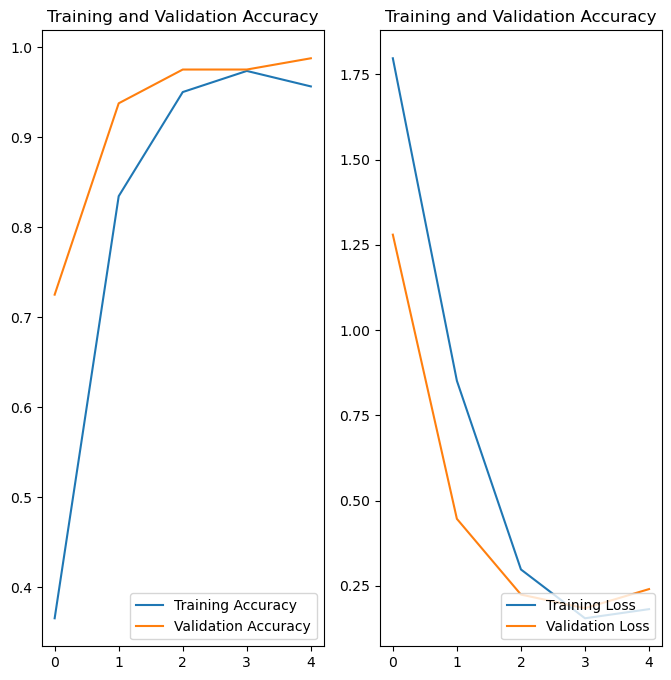

In [77]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(5),acc,label='Training Accuracy')
plt.plot(range(5),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(5),loss,label='Training Loss')
plt.plot(range(5),val_loss,label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

1 image to predict
Actual label: 4
1/1 [==============================] - 0s 317ms/step
Predicted label: 4
2 image to predict
Actual label: 3
1/1 [==============================] - 0s 163ms/step
Predicted label: 3
3 image to predict
Actual label: 7
1/1 [==============================] - 0s 169ms/step
Predicted label: 7
4 image to predict
Actual label: 2
1/1 [==============================] - 0s 169ms/step
Predicted label: 2
5 image to predict
Actual label: 6
1/1 [==============================] - 0s 167ms/step
Predicted label: 6
6 image to predict
Actual label: 6
1/1 [==============================] - 0s 152ms/step
Predicted label: 6
7 image to predict
Actual label: 5
1/1 [==============================] - 0s 152ms/step
Predicted label: 5
8 image to predict
Actual label: 5
1/1 [==============================] - 0s 163ms/step
Predicted label: 5
9 image to predict
Actual label: 5
1/1 [==============================] - 0s 154ms/step
Predicted label: 5
10 image to predict
Actual label: 6
1

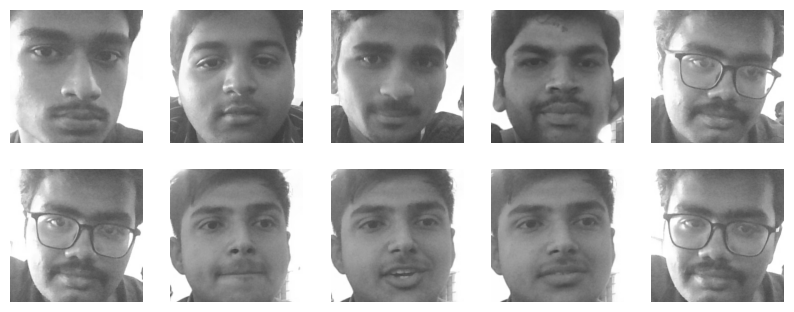

In [78]:
plt.figure(figsize=(10,10))
for img_batch, labels_batch in testds.take(1):
    for i in range(10):
        plt.subplot(5,5,i+1)
        plt.axis("off")
        first_img=img_batch[i].numpy().astype('uint8')
        first_label=labels_batch[i].numpy()
    
        print(str(i+1)+" image to predict")
        plt.imshow(first_img)
        print("Actual label:",classnm[first_label])
    
        batch_prediction=model.predict(img_batch)
        print("Predicted label:",classnm[np.argmax(batch_prediction[i])])

In [ ]:
def predict(test_batch):
    #plt.figure(figsize=(10,10))
    for img_batch, labels_batch in test_batch.take(1):
        for i in range(10):
        #    plt.subplot(5,5,i+1)
        #    plt.axis("off")
            first_img=img_batch[i].numpy().astype('uint8')
            first_label=labels_batch[i].numpy()
            print(str(i+1)+" image to predict")
            plt.imshow(first_img)
            print("Actual label:",classnm[first_label])
    
            batch_prediction=model.predict(img_batch)
            print("Predicted label:",classnm[np.argmax(batch_prediction[i])])

In [6]:
cascpath="haarcascade_frontalface_default.xml"
face_cas = cv2.CascadeClassifier(cascpath)
cap = cv2.VideoCapture(0)
font = cv2.FONT_HERSHEY_SIMPLEX
c=0
while True:
    ret, img = cap.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cas.detectMultiScale(gray, 1.3, 7)
    for (x, y, w, h) in faces:
        cropped_face = img[y:y+h,x:x+w]
        #roi_gray = gray[y:y + h, x:x + w]
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
        face = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2GRAY)
        c+=1
        file_name_path = "TestDataset/"+"/"+str(c)+'.jpg'
        cv2.imwrite(file_name_path, face)
        #test_batch=tf.keras.preprocessing.image_dataset_from_directory(
         #        "TestDataset",
        #         shuffle=True,
        #         image_size=(imgsize,imgsize),
        #         batch_size=10
        #)
        #predict()

    

        #cv2.putText(img, str(id) + " " + str(conf), (x, y - 10), font, 0.55, (120, 255, 120), 1)
     
    cv2.imshow('frame', img)

    if cv2.waitKey(50) or c==10:
        break

cap.release()
cv2.destroyAllWindows()

In [5]:
test_batch=tf.keras.preprocessing.image_dataset_from_directory(
                "TestDataset",
                 shuffle=True,
                 image_size=(imgsize,imgsize),
                 batch_size=10
)

Found 0 files belonging to 0 classes.


ValueError: No images found in directory TestDataset. Allowed formats: ('.bmp', '.gif', '.jpeg', '.jpg', '.png')